# INFO-F-422 -  Statistical Foundations of Machine Learning 

### Student 1 - __[student1@ulb.ac.be](mailto:student1@ulb.ac.be) - Student ID 123456__
### Student 2 - __[student2@vub.ac.be](mailto:student2@ulb.ac.be) - Student ID 789012__
### Student 3 - __[student3@ulb.ac.be](mailto:student3@ulb.ac.be) - Student ID 345678__

### Video presentation: www.youtube.com/abcd1234

## Project Title


# Introduction


# 1. Data preprocessing


### 1.1 Loading the data

In [17]:
library(fastDummies)
library(reshape2)
library(dplyr)
library(tibble)
library(ggplot2)

test_set=read.csv("test_set_features.csv",header=TRUE)                
training_label=read.csv("training_set_labels.csv",header=TRUE)
training_feature=read.csv("training_set_features.csv",header=TRUE)  

submission=read.csv("submission_format.csv",header = TRUE)

feature_df<-dplyr::tibble(training_feature)
labels_df<-dplyr::tibble(training_label)
training_df<-dplyr::inner_join(feature_df,labels_df)


Attachement du package : ‘dplyr’


Les objets suivants sont masqués depuis ‘package:stats’:

    filter, lag


Les objets suivants sont masqués depuis ‘package:base’:

    intersect, setdiff, setequal, union


Joining, by = "respondent_id"


Checking the data

In [22]:
dim(training_df)
summary(training_df)

[1] 26707    38

 respondent_id    h1n1_concern   h1n1_knowledge  behavioral_antiviral_meds
 Min.   :    0   Min.   :0.000   Min.   :0.000   Min.   :0.00000          
 1st Qu.: 6676   1st Qu.:1.000   1st Qu.:1.000   1st Qu.:0.00000          
 Median :13353   Median :2.000   Median :1.000   Median :0.00000          
 Mean   :13353   Mean   :1.618   Mean   :1.263   Mean   :0.04884          
 3rd Qu.:20030   3rd Qu.:2.000   3rd Qu.:2.000   3rd Qu.:0.00000          
 Max.   :26706   Max.   :3.000   Max.   :2.000   Max.   :1.00000          
                 NA's   :92      NA's   :116     NA's   :71               
 behavioral_avoidance behavioral_face_mask behavioral_wash_hands
 Min.   :0.0000       Min.   :0.00000      Min.   :0.0000       
 1st Qu.:0.0000       1st Qu.:0.00000      1st Qu.:1.0000       
 Median :1.0000       Median :0.00000      Median :1.0000       
 Mean   :0.7256       Mean   :0.06898      Mean   :0.8256       
 3rd Qu.:1.0000       3rd Qu.:0.00000      3rd Qu.:1.0000       
 Max.   :1

Our training set is composed of 20707 rows and 38 variables (37 without id).


[1] "age_group"             "education"             "race"                 
 [4] "sex"                   "income_poverty"        "marital_status"       
 [7] "rent_or_own"           "employment_status"     "hhs_geo_region"       
[10] "census_msa"            "employment_industry"   "employment_occupation"

      respondent_id
1                 0
2                 1
3                 2
4                 3
5                 4
6                 5
7                 6
8                 7
9                 8
10                9
11               10
12               11
13               12
14               13
15               14
16               15
17               16
18               17
19               18
20               19
21               20
22               21
23               22
24               23
25               24
26               25
27               26
28               27
29               28
30               29
31               30
32               31
33               32
34               33
35               34
36               35
37               36
38               37
39               38
40               39
41               40
42               41
43               42
44               43
45               44
46               45
47               46
48               47
49               48


respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,⋯,employment_occupation_qxajmpny,employment_occupation_rcertsgn,employment_occupation_tfqavkke,employment_occupation_ukymxvdu,employment_occupation_uqqtjvyb,employment_occupation_vlluhbov,employment_occupation_xgwztkwe,employment_occupation_xqwwgdyp,employment_occupation_xtkaffoo,employment_occupation_xzmlyyjv
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,1,0,0,0,0,0,0,1,1,⋯,0,0,0,0,0,0,0,0,0,0
1,3,2,0,1,0,1,0,1,1,⋯,0,0,0,0,0,0,1,0,0,0
2,1,1,0,1,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,1,0
3,1,1,0,1,0,1,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,2,1,0,1,0,1,1,0,1,⋯,0,0,0,0,0,0,0,0,0,0
5,3,1,0,1,0,1,0,0,1,⋯,0,0,0,0,0,1,0,0,0,0
6,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,1,0
7,1,0,0,1,0,1,0,0,1,⋯,0,0,0,0,0,0,0,1,0,0
8,0,2,0,1,0,1,1,1,1,⋯,0,0,0,0,0,0,0,0,0,0


Var1,Var2,value
<fct>,<fct>,<dbl>
marital_status_,education_,0.89
employment_status_,education_,0.86
sex_Male,sex_Female,-1.00
sex_Female,sex_Male,-1.00
education_,marital_status_,0.89
employment_status_,marital_status_,0.88
marital_status_Not.Married,marital_status_Married,-0.90
marital_status_Married,marital_status_Not.Married,-0.90
rent_or_own_Rent,rent_or_own_Own,-0.82


Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(droped_variable)` instead of `droped_variable` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.


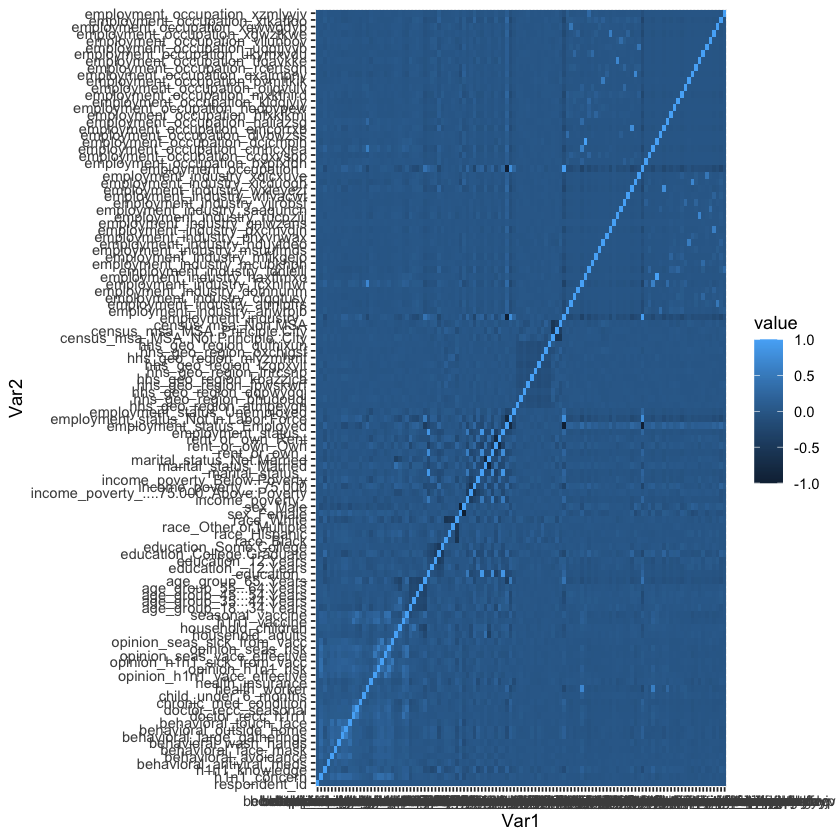

respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,⋯,employment_occupation_qxajmpny,employment_occupation_rcertsgn,employment_occupation_tfqavkke,employment_occupation_ukymxvdu,employment_occupation_uqqtjvyb,employment_occupation_vlluhbov,employment_occupation_xgwztkwe,employment_occupation_xqwwgdyp,employment_occupation_xtkaffoo,employment_occupation_xzmlyyjv
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0.3333333,0.0,0,0,0,0,0,1,1,⋯,0,0,0,0,0,0,0,0,0,0
1,1.0000000,1.0,0,1,0,1,0,1,1,⋯,0,0,0,0,0,0,1,0,0,0
2,0.3333333,0.5,0,1,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,1,0
3,0.3333333,0.5,0,1,0,1,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,0.6666667,0.5,0,1,0,1,1,0,1,⋯,0,0,0,0,0,0,0,0,0,0
5,1.0000000,0.5,0,1,0,1,0,0,1,⋯,0,0,0,0,0,1,0,0,0,0
6,0.0000000,0.0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,1,0
7,0.3333333,0.0,0,1,0,1,0,0,1,⋯,0,0,0,0,0,0,0,1,0,0
8,0.0000000,1.0,0,1,0,1,1,1,1,⋯,0,0,0,0,0,0,0,0,0,0


h1n1_concern 
                            0.5394952721 
                          h1n1_knowledge 
                            0.6312662179 
               behavioral_antiviral_meds 
                            0.0488436702 
                    behavioral_avoidance 
                            0.7256122873 
                    behavioral_face_mask 
                            0.0689823141 
                   behavioral_wash_hands 
                            0.8256141009 
             behavioral_large_gatherings 
                            0.3586401202 
                 behavioral_outside_home 
                            0.3373145540 
                   behavioral_touch_face 
                            0.6772640054 
                        doctor_recc_h1n1 
                            0.2203120544 
                    doctor_recc_seasonal 
                            0.3297347945 
                   chronic_med_condition 
                            0.2832608020 
                    child_under_6_months 
                            0.0825897168 
                           health_worker 
                            0.1119175385 
                        health_insurance 
                            0.8797200859 
             opinion_h1n1_vacc_effective 
                            0.7701246390 
                       opinion_h1n1_risk 
                            0.4685132414 
             opinion_h1n1_sick_from_vacc 
                            0.4715339009 
             opinion_seas_vacc_effective 
                            0.8051971804 
                       opinion_seas_risk 
                            0.5438323216 
             opinion_seas_sick_from_vacc 
                            0.4236224685 
                        household_adults 
                            0.2954997858 
                      household_children 
                            0.1781943710 
                 age_group_18...34.Years 
                            0.1952671584 
                 age_group_35...44.Years 
                            0.1440820759 
                 age_group_45...54.Years 
                            0.1961283559 
                 age_group_55...64.Years 
                            0.2082974501 
                     age_group_65..Years 
                            0.2562249597 
                    education_..12.Years 
                            0.0884786760 
                      education_12.Years 
                            0.2170591980 
              education_College.Graduate 
                            0.3780656757 
                  education_Some.College 
                            0.2637136331 
                              race_Black 
                            0.0793050511 
                           race_Hispanic 
                            0.0657131089 
                  race_Other.or.Multiple 
                            0.0603587075 
                              race_White 
                            0.7946231325 
                                sex_Male 
                            0.4062230876 
                         income_poverty_ 
                            0.1656120118 
income_poverty_....75.000..Above.Poverty 
                            0.4784138990 
                income_poverty_...75.000 
                            0.2549893286 
            income_poverty_Below.Poverty 
                            0.1009847605 
                  marital_status_Married 
                            0.5075448384 
                            rent_or_own_ 
                            0.0764593552 
                        rent_or_own_Rent 
                            0.2220017224 
                      employment_status_ 
                            0.0547796458 
    employment_status_Not.in.Labor.Force 
                            0.3830830868 
            employment_status_Unemployed 
                            0.0544052121 
                 hhs_geo_region_atmpeygn 
                            0.07612236

h1n1_concern 
                           -1.508495e-17 
                          h1n1_knowledge 
                           -3.687323e-17 
               behavioral_antiviral_meds 
                            1.512812e-18 
                    behavioral_avoidance 
                           -5.085459e-17 
                    behavioral_face_mask 
                           -1.078969e-18 
                   behavioral_wash_hands 
                            3.550875e-17 
             behavioral_large_gatherings 
                            5.820126e-18 
                 behavioral_outside_home 
                           -2.257800e-17 
                   behavioral_touch_face 
                           -1.242114e-17 
                        doctor_recc_h1n1 
                           -1.280011e-17 
                    doctor_recc_seasonal 
                           -1.016496e-18 
                   chronic_med_condition 
                           -7.563937e-18 
                    child_under_6_months 
                            8.452074e-18 
                           health_worker 
                            6.341921e-18 
                        health_insurance 
                           -6.309562e-19 
             opinion_h1n1_vacc_effective 
                            2.513083e-17 
                       opinion_h1n1_risk 
                            2.208221e-17 
             opinion_h1n1_sick_from_vacc 
                            1.491683e-17 
             opinion_seas_vacc_effective 
                            4.598068e-17 
                       opinion_seas_risk 
                            1.287735e-17 
             opinion_seas_sick_from_vacc 
                            2.423561e-17 
                        household_adults 
                           -1.721837e-17 
                      household_children 
                            9.017629e-19 
                 age_group_18...34.Years 
                            7.232393e-18 
                 age_group_35...44.Years 
                           -7.597323e-18 
                 age_group_45...54.Years 
                            1.559272e-17 
                 age_group_55...64.Years 
                           -1.548711e-17 
                     age_group_65..Years 
                            2.003813e-17 
                    education_..12.Years 
                            2.478979e-18 
                      education_12.Years 
                           -4.654281e-19 
              education_College.Graduate 
                            2.448950e-17 
                  education_Some.College 
                           -5.365012e-18 
                              race_Black 
                            3.912483e-18 
                           race_Hispanic 
                            3.628248e-19 
                  race_Other.or.Multiple 
                           -6.082573e-18 
                              race_White 
                           -1.691323e-17 
                                sex_Male 
                            5.063239e-18 
                         income_poverty_ 
                           -1.743611e-18 
income_poverty_....75.000..Above.Poverty 
                            1.290028e-17 
                income_poverty_...75.000 
                            1.318909e-17 
            income_poverty_Below.Poverty 
                            3.748250e-19 
                  marital_status_Married 
                           -2.019896e-17 
                            rent_or_own_ 
                            4.130152e-18 
                        rent_or_own_Rent 
                           -1.954263e-17 
                      employment_status_ 
                           -6.548133e-19 
    employment_status_Not.in.Labor.Force 
                           -1.511690e-17 
            employment_status_Unemployed 
                            8.506110e-19 
                 hhs_geo_region_atmpeygn 
                           -2.083525e-

Joining, by = "respondent_id"
Joining, by = "respondent_id"


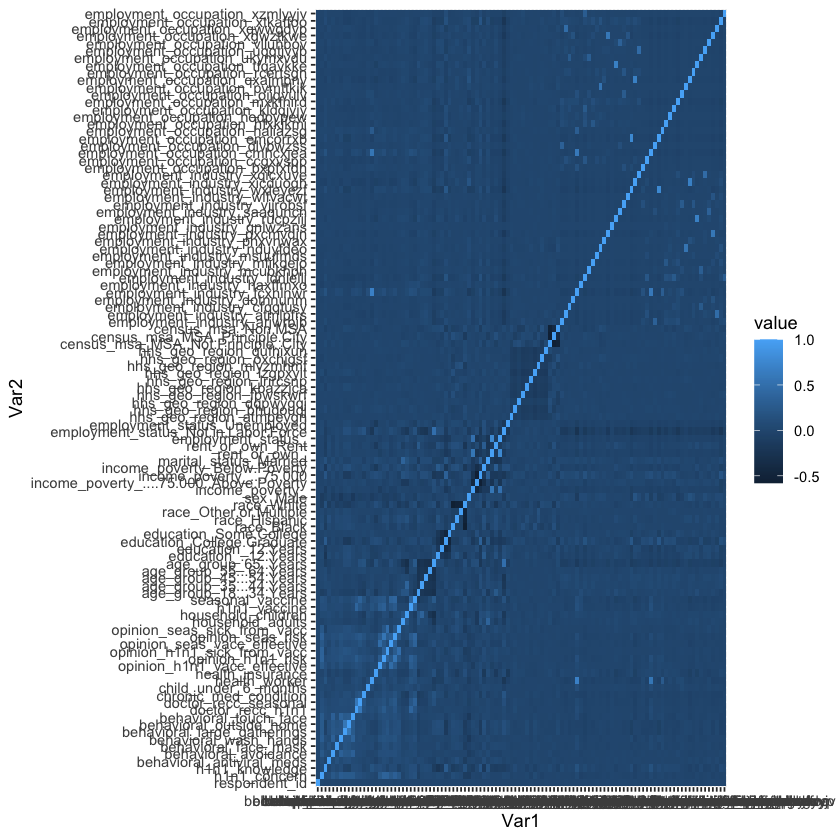

In [21]:
category_list=c()
for (feature in colnames(training_df)){
  if (typeof(training_df[feature][[1]])=="character"){
    category_list<-c(category_list,feature)
  }
}
category_list
dummy_df<-fastDummies::dummy_cols(training_df)
no_category_df<-select(dummy_df,!category_list)
n
# Replace NaN value for integer feature with the mean of the feature
replace_na_with_mean_value<-function(vec) {
  mean_vec<-mean(vec,na.rm=T)
  vec[is.na(vec)]<-mean_vec
  vec
}
df_preprocessed<-data.frame(apply(no_category_df,2,replace_na_with_mean_value))
for (feature in colnames(df_preprocessed)){
  print(unique(df_preprocessed[feature]))
}
#Preprocessed dataframe
df_preprocessed

#Correlation matrix with Pearson method
cormat <- round(cor(df_preprocessed, method='pearson'),2)

#Put Correaltion matrix in a form suitable to build heatmap
melted_cormat <- melt(cormat)

#Heatmap
pearson_heatmap<-ggplot(data = melted_cormat, aes(x=Var1, y=Var2, fill=value)) + 
  geom_tile()
pearson_heatmap

#Check for highly correlated value (>0.8)
high_correl_variable<-dplyr::filter(melted_cormat,abs(value)>0.8)
high_correl_variable<-dplyr::filter(high_correl_variable,Var1!=Var2)
high_correl_variable
# When two feature are highly correlated we could keep only one of the two <- only old character field are concerned 
droped_variable<-c('education_','sex_Female','marital_status_','marital_status_Not.Married','rent_or_own_Own','employment_occupation_','employment_occupation_dcjcmpih','employment_industry_','employment_status_Employed')
first_selection_df<-dplyr::select(df_preprocessed,-droped_variable)

#Rebuild new Heatmap after feature suppression
cormat <- round(cor(first_selection_df, method='pearson'),2)
melted_cormat <- melt(cormat)
pearson_heatmap<-ggplot(data = melted_cormat, aes(x=Var1, y=Var2, fill=value)) + 
  geom_tile()
pearson_heatmap

#LDA -> NN

#Start of the LDA algorithm to select feature


#Normalization of the feature to [0,1]
first_selection_df<-dplyr::select(first_selection_df,-c('h1n1_vaccine','seasonal_vaccine'))

for (feature in colnames(first_selection_df)){
  if (feature!='respondent_id'){
  norm_factor=max(first_selection_df[feature])
  first_selection_df[feature]<-(first_selection_df[feature])/norm_factor
  }
}
first_selection_df

#Get the mean of each feature to be able to center the data
mean_vector<-apply(dplyr::select(first_selection_df,-'respondent_id'),2,mean)
mean_vector

#Center the data
centered_df<-sweep(dplyr::select(first_selection_df,-'respondent_id'),MARGIN = 2,STATS = mean_vector,FUN = '-')
centered_df['respondent_id']<-first_selection_df['respondent_id']

#Check that it is indeed centered
mean_centered<-apply(centered_df,2,mean)
mean_centered 

#Bringing the labels back in the picture
h1n1_centered<-dplyr::inner_join(centered_df,df_preprocessed[c('respondent_id','h1n1_vaccine')])
seasonal_centered<-dplyr::inner_join(centered_df,df_preprocessed[c('respondent_id','seasonal_vaccine')])

#Get the mean when grouping with respect to label value (=mean per category) :
h1n1_col_means_class<-h1n1_centered%>% group_by(h1n1_vaccine)%>% summarise(across(.cols = everything(), .fns = mean))
seasonal_col_means_class<-seasonal_centered%>% group_by(seasonal_vaccine)%>% summarise(across(.cols = everything(), .fns = mean))

#To pursue

## Missing value imputation

## Feature engineering

## Feature selection


# Model selection

## Model 1

## Model 2

## Model 3

#### Example of simple equation
\begin{equation}
e = mc^2
\end{equation}

#### Example of matrix equation - Cross product formula:

\begin{equation*}
\mathbf{V}_1 \times \mathbf{V}_2 =  \begin{vmatrix}
\mathbf{i} & \mathbf{j} & \mathbf{k} \\
\frac{\partial X}{\partial u} &  \frac{\partial Y}{\partial u} & 0 \\
\frac{\partial X}{\partial v} &  \frac{\partial Y}{\partial v} & 0
\end{vmatrix}
\end{equation*}

#### Example of multiline equation - The Lorenz Equations:

\begin{align}
\dot{x} & = \sigma(y-x) \\
\dot{y} & = \rho x - y - xz \\
\dot{z} & = -\beta z + xy
\end{align}

#### Example of Markdown Table:

| This | is   |
|------|------|
|   a  | table|


# Alternative models





# Conclusions